In [20]:
import os
import tabulate
import pandas as pd
import yaml
import json
import numpy as np

dir = "experiments"

skip = [
    "150 Epochs",
    "5 Epochs",
]


def flatten_dict(d, parent_key="", sep="."):
    """Flattens a nested dictionary."""
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def parse_yaml(file_name: str, data: dict) -> dict:
    if not (file_name.endswith(".yml") or file_name.endswith(".yaml")):
        return data

    file_path = os.path.join(experiment_dir, file_name)
    with open(file_path, "r") as file:
        yaml_content = yaml.safe_load(file)
        # Flatten the YAML content and add the file name as a column
        flat_content = flatten_dict(yaml_content)
    return data | flat_content


def parse_results(file_name: str, data: dict) -> dict:
    if not file_name.endswith(".json"):
        return data

    file_path = os.path.join(experiment_dir, file_name)
    with open(file_path, "r") as file:
        json_content = json.load(file)
    return data | json_content

def highlight_row_based_on_baseline(row):
    if row['baseline'] == True:  # Check if 'baseline' is True
        return ['background-color: #574800'] * len(row)
    else:
        return [''] * len(row)

# Function to highlight rows based on index
def highlight_row(row, idx):
    if row.name == idx:
        return ['background: darkgreen'] * len(row)
    else:
        return [''] * len(row)

all_data = []
all_val_results = []
all_test_results = []
for experiment in os.listdir(dir):
    experiment_name = experiment.split("_")[1]
    if experiment_name in skip:
        continue
    # if experiment != "20241208-213746_focal":
    #     continue

    experiment_data = {}
    val_results = {}
    test_results = []
    experiment_dir = os.path.join(dir, experiment)
    for file_name in os.listdir(experiment_dir):
        experiment_data = parse_yaml(file_name, experiment_data)
        if "val" in file_name:
            val_results = parse_results(file_name, {})
        if "20241208-213746_focal" == experiment:
            if "test" in file_name:
                test_results.append(parse_results(file_name, {}))

    if "baseline" in experiment_name:
        experiment_data["baseline"] = True

    # If the data is not empty, add it to the list
    if experiment_data != {}:
        all_data.append(experiment_data)
    all_val_results.append(val_results)
    if test_results != []:
        all_test_results = (test_results)

config_df = pd.DataFrame(all_data)
del config_df["experiment_config.loader_params.data_dir"]
del config_df["experiment_config.loader_params.seed"]
del config_df["experiment_config.train.save_on_metric"]
config_df = config_df.rename(
    columns={
        "experiment_config.loader_params.batch_size": "batch_size",
        "experiment_config.train.max_epochs": "max_epochs",
        "experiment_config.criterion.name": "criterion",
        "experiment_config.optimizer.name": "optimizer",
        "experiment_config.optimizer.lr": "lr",
        "experiment_config.criterion.alpha": "FL_alpha",
        "experiment_config.criterion.gamma": "FL_gamma",
    }
)

# Function to parse the transforms column and extract p values
def parse_transforms(cell):
    try:
        # Create a dictionary with transform names as keys and their 'p' values
        transform_dict = {"A."+transform['name']: transform['params']['p'] for transform in cell}
        return transform_dict
    except Exception as e:
        return {}  # Return an empty dictionary if parsing fails

def highlight_cols(s, collist):
    if s.name in collist:
        return ['background-color: darkgreen'] * len(s)
    return [''] * len(s)

# Apply the function to parse each cell in the transforms column
parsed_transforms = config_df['transforms'].apply(parse_transforms)

# Create a DataFrame from the parsed transforms
parsed_df = pd.DataFrame(parsed_transforms.tolist()).fillna(np.nan)  # Fill missing values with 0

# Merge the parsed DataFrame back into the original DataFrame (optional)
config_df = pd.concat([config_df.drop(columns=['transforms']), parsed_df], axis=1)

# lr
# drop = [0,6,7,8,10,13,4,2,11,3,12]
# drop = [0,6,7,8,10,13,4,2,11,1,9]
# collist = [
#     "lr",
# ]

# # criterion
# drop = [12, 9, 7, 6, 5, 0, 1, 3] old
# collist = [
#     "criterion",
#     "FL_alpha",
#     "FL_gamma",
# ]

# # aug
# drop = [1, 2, 8, 10, 5, 9, 12, 3] old
# collist = [
#     "A.RandomBrightnessContrast",
# ]

# # augmentation
# drop = [0,2,3,7,8,11,12,1,6,10,13]
# collist = [
#     "A.HorizontalFlip",
#     "A.VerticalFlip",
#     "A.RandomRotate90",
#     "A.Transpose",
# ]

# drop =[0,1,2,3,5,6,7,8,9,10,12]
# config_df.drop(index=drop, inplace=True)

styled_df = (
    config_df.style
    # .apply(highlight_row, idx=11, axis=1)
    # .apply(highlight_cols, collist=collist)
    # .apply(highlight_row_based_on_baseline, axis=1)
)
styled_df

,batch_size,max_epochs,criterion,FL_alpha,FL_gamma,optimizer,lr,baseline,A.HorizontalFlip,A.VerticalFlip,A.RandomRotate90,A.Transpose,A.RandomBrightnessContrast
0,32,75,FocalLoss,1.000000,2.000000,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,0.750000
1,32,75,BCEWithLogitsLoss,nan,nan,AdamW,0.000500,nan,0.500000,0.500000,0.500000,0.500000,nan
2,32,75,FocalLoss,1.000000,3.000000,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,nan
3,32,75,FocalLoss,1.000000,2.000000,AdamW,0.000500,nan,0.500000,0.500000,0.500000,0.500000,nan
4,32,75,BCEWithLogitsLoss,nan,nan,AdamW,0.000100,nan,nan,nan,nan,nan,nan
5,32,75,BCEWithLogitsLoss,nan,nan,AdamW,0.000100,True,0.500000,0.500000,0.500000,0.500000,nan
6,32,75,BCEWithLogitsLoss,nan,nan,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,0.750000
7,32,75,FocalLoss,1.000000,2.000000,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,0.500000
8,32,75,FocalLoss,1.000000,2.000000,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,0.200000
9,32,75,BCEWithLogitsLoss,nan,nan,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,nan


In [37]:
def style_results(df):
    # List of columns to apply the gradient
    selected_columns = ["val_loss", "iou_score", "dice_score", "pixel_acc", "recall", "precision", "f1", "specificity"]

    # Default for all cells
    styled_df = df.style.apply(
        lambda x: ["background-color: "] * len(x), axis=1
    ) 

    # Apply gradient only to selected columns
    for col in selected_columns:
        if col not in df.columns:
            continue
        styled_df = styled_df.background_gradient(subset=[col], cmap="coolwarm")
    return styled_df

results_df = pd.DataFrame(all_val_results)
# results_df.drop(index=[0,1,2,3,5,6,7,8,9,10,12], inplace=True)
# results_df.drop(index=drop, inplace=True)
style_results(results_df)

,val_loss,iou_score,dice_score,pixel_acc,threshold,TP,TN,FP,FN
0,0.011557,0.271627,0.346553,0.988455,nan,nan,nan,nan,nan
1,0.042482,0.286249,0.362244,0.988111,nan,nan,nan,nan,nan
2,0.006259,0.284623,0.363539,0.988502,nan,nan,nan,nan,nan
3,0.011532,0.290540,0.370652,0.988478,nan,nan,nan,nan,nan
4,0.054636,0.248835,0.317978,0.987544,nan,nan,nan,nan,nan
5,0.068225,0.150704,0.204614,0.983719,nan,nan,nan,nan,nan
6,0.043088,0.262646,0.335545,0.988421,nan,nan,nan,nan,nan
7,0.012194,0.277490,0.354045,0.987732,nan,nan,nan,nan,nan
8,0.011226,0.295780,0.374125,0.988257,nan,nan,nan,nan,nan
9,0.041500,0.284892,0.366608,0.988515,nan,nan,nan,nan,nan


In [191]:
# Combine val results and config
combined_df = pd.concat([config_df, results_df], axis=1)
style_results(combined_df)

,batch_size,max_epochs,criterion,FL_alpha,FL_gamma,optimizer,lr,baseline,A.HorizontalFlip,A.VerticalFlip,A.RandomRotate90,A.Transpose,A.RandomBrightnessContrast,val_loss,iou_score,dice_score,pixel_acc
0,32,75,FocalLoss,1.000000,2.000000,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,0.750000,0.011557,0.271627,0.346553,0.988455
1,32,75,BCEWithLogitsLoss,nan,nan,AdamW,0.000500,nan,0.500000,0.500000,0.500000,0.500000,nan,0.042482,0.286249,0.362244,0.988111
2,32,75,FocalLoss,1.000000,3.000000,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,nan,0.006259,0.284623,0.363539,0.988502
3,32,75,FocalLoss,1.000000,2.000000,AdamW,0.000500,nan,0.500000,0.500000,0.500000,0.500000,nan,0.011532,0.290540,0.370652,0.988478
4,32,75,BCEWithLogitsLoss,nan,nan,AdamW,0.000100,nan,nan,nan,nan,nan,nan,0.054636,0.248835,0.317978,0.987544
5,32,75,BCEWithLogitsLoss,nan,nan,AdamW,0.000100,True,0.500000,0.500000,0.500000,0.500000,nan,0.068225,0.150704,0.204614,0.983719
6,32,75,BCEWithLogitsLoss,nan,nan,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,0.750000,0.043088,0.262646,0.335545,0.988421
7,32,75,FocalLoss,1.000000,2.000000,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,0.500000,0.012194,0.277490,0.354045,0.987732
8,32,75,FocalLoss,1.000000,2.000000,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,0.200000,0.011226,0.295780,0.374125,0.988257
9,32,75,BCEWithLogitsLoss,nan,nan,AdamW,0.000100,nan,0.500000,0.500000,0.500000,0.500000,nan,0.041500,0.284892,0.366608,0.988515


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
results_df = pd.DataFrame(all_test_results)
def calculate_recall(df):
    df['recall'] = df['TP'] / (df['TP'] + df['FN'])
    return df
def calculate_precision(df):
    df['precision'] = df['TP'] / (df['TP'] + df['FP'])
    return df
def calcualte_f1(df):
    df['f1'] = 2 * (df['precision'] * df['recall']) / (df['precision'] + df['recall'])
    return df
# def calculate_specificity(df):
#     df['specificity'] = df['TN'] / (df['TN'] + df['FP'])
#     return df
results_df = results_df.apply(calculate_recall, axis=1)
results_df = results_df.apply(calculate_precision, axis=1)
results_df = results_df.apply(calcualte_f1, axis=1)
# results_df = results_df.apply(calculate_specificity, axis=1)
# sort by threshold
results_df = results_df.sort_values(by=['threshold'])
# results_df.drop(index=[0,1,2,3,5,6,7,8,9,10,12], inplace=True)

# drop tp, tn, fp, fn
style_results(results_df.drop(columns=['TP', 'TN', 'FP', 'FN']))

,threshold,val_loss,iou_score,dice_score,pixel_acc,recall,precision,f1
2,0.100000,0.011853,0.165310,0.254072,0.937227,0.958016,0.215795,0.352245
6,0.200000,0.011853,0.234630,0.342390,0.966929,0.912299,0.340300,0.495698
3,0.300000,0.011853,0.292210,0.403334,0.978671,0.861849,0.448674,0.590130
8,0.400000,0.011853,0.332194,0.435978,0.985299,0.780673,0.563056,0.654243
0,0.500000,0.011853,0.321797,0.413732,0.988165,0.632125,0.680753,0.655538
5,0.600000,0.011853,0.226554,0.303031,0.987651,0.407047,0.802484,0.540124
1,0.700000,0.011853,0.102214,0.148121,0.985279,0.195192,0.900806,0.320858
7,0.800000,0.011853,0.031073,0.047394,0.983390,0.069432,0.975698,0.129639
4,0.900000,0.011853,0.005202,0.008139,0.982352,0.009464,0.996324,0.018751


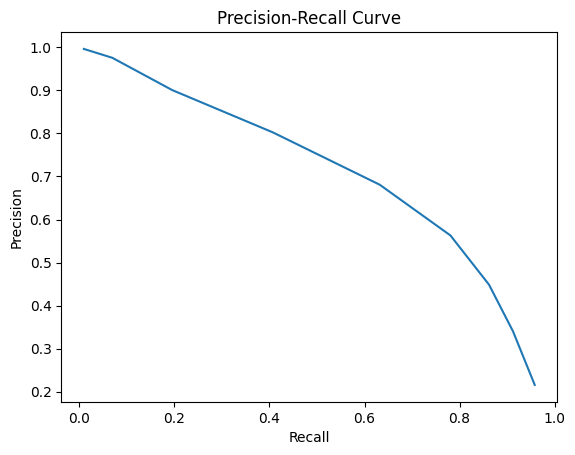

In [55]:
# display precision and recall curve


precision = results_df['precision']
recall = results_df['recall']

plt.plot(recall, precision)

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

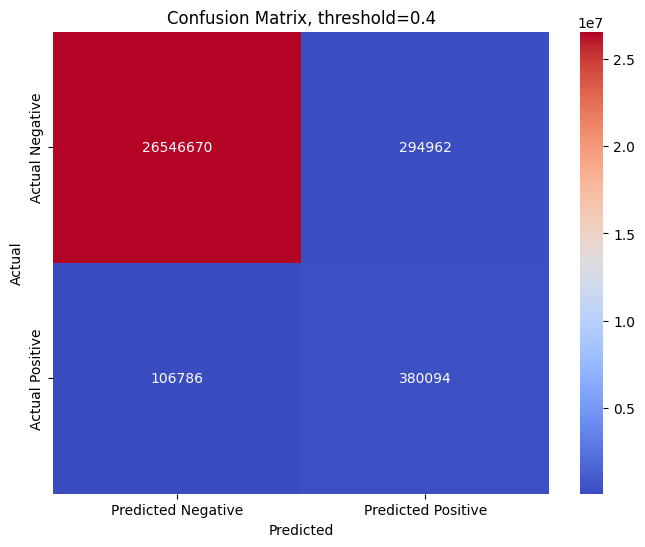

In [79]:
# show confusion matrix of tp, tn, fp, fn
# Extract values
index = 8
tp = results_df['TP'][index].astype(int)
fn = results_df['FN'][index].astype(int)
fp = results_df['FP'][index].astype(int)
tn = results_df['TN'][index].astype(int)

# Construct confusion matrix
confusion_matrix = pd.DataFrame(
    [[tn, fp],
     [fn, tp]],
    index=['Actual Negative', 'Actual Positive'],
    columns=['Predicted Negative', 'Predicted Positive']
)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.title(f'Confusion Matrix, threshold={results_df["threshold"][index]}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()